In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import f_oneway, ttest_ind
from Architectures.AE import AE1

In [3]:
all_images = []
for group in ["CN","MCI","AD"]:
    with open(f"Data/{group}.npy","br") as f:
        images = np.load(f)
    i_start = len(all_images)
    all_images.extend(images)
    print(group, i_start,":",len(all_images))
all_images = np.stack(all_images)
print(all_images.shape)

CN 0 : 1326
MCI 1326 : 1787
AD 1787 : 2000
(2000, 80, 96, 80)


In [6]:
models = [AE1.open(f"Trained Models/AE/{d}") for d in [10,30,50,100,300]]
print("Done loading models. Now generating latent space for first model.")
latent = models[0].encode(all_images)

Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Done loading models. Now generating latent space for first model.
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\3723901779.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


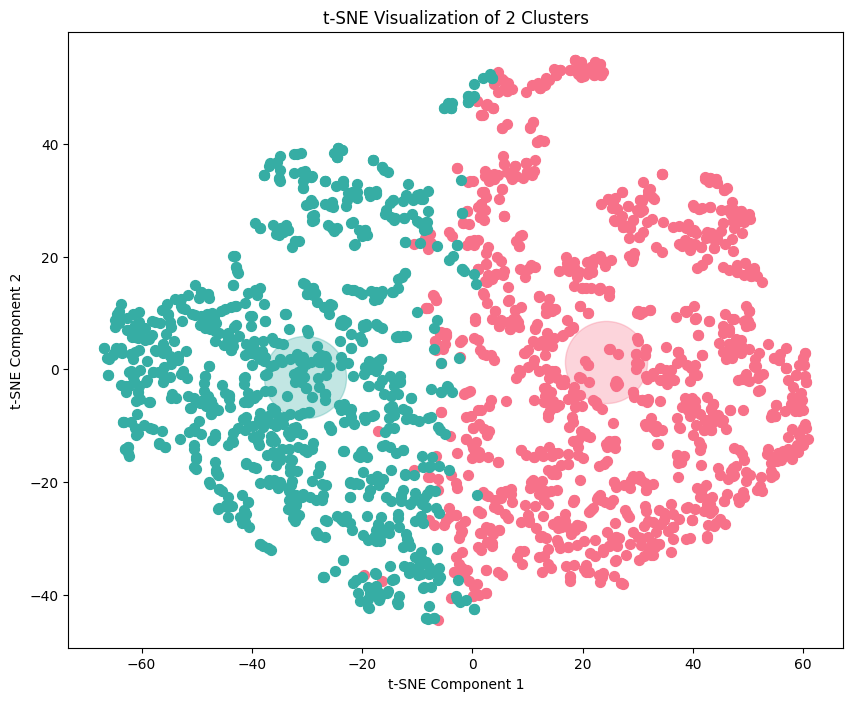

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\3723901779.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


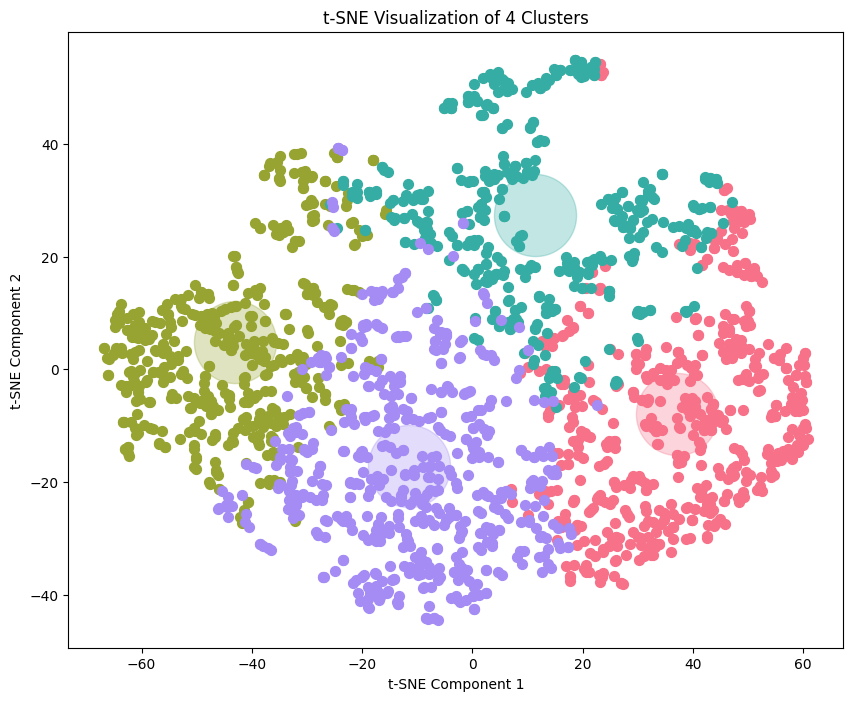

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\3723901779.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


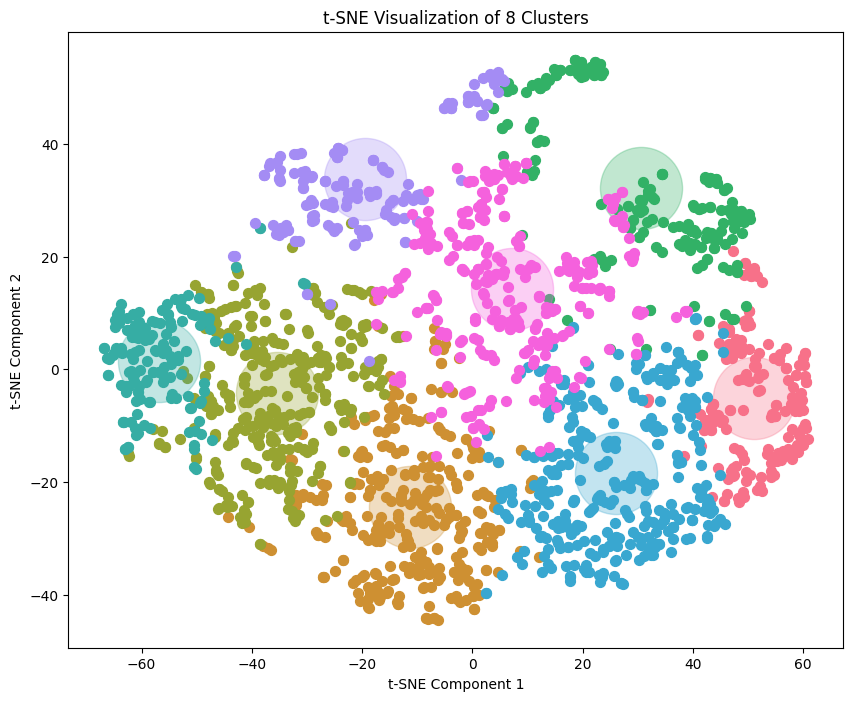

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\3723901779.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


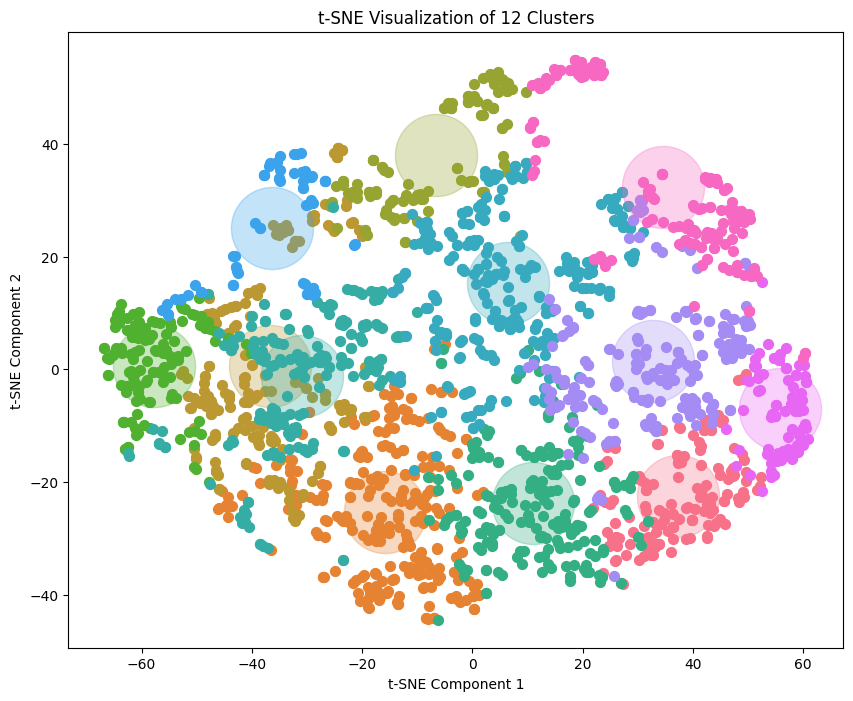

In [16]:
def find_clusters(data, n_clusters=3):
    """
    Perform clustering on MRI latent space data and calculate p-values.
    
    Parameters:
    data (numpy.ndarray): A matrix of shape (n_samples, m_features).
    n_clusters (int): Number of clusters to form.
    
    Returns:
    tuple: Cluster labels for each sample, p-values for samples, p-values for clusters.
    """
    
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    
    # Calculate p-values for each feature using ANOVA
    p_values_samples = []
    for i in range(data.shape[1]):
        feature_data = [data[labels == cluster, i] for cluster in range(n_clusters)]
        f_stat, p_value = f_oneway(*feature_data)
        p_values_samples.append(p_value)
    
    # # Calculate p-values for clusters using t-test (pairwise comparisons)
    # p_values_clusters = np.ones((n_clusters, n_clusters))
    # for i in range(n_clusters):
    #     for j in range(i+1, n_clusters):
    #         t_stat, p_value = ttest_ind(data[labels == i], data[labels == j], equal_var=False)
    #         print(p_value)
    #         p_values_clusters[i, j] = p_value
    #         p_values_clusters[j, i] = p_value
    
    return labels, np.array(p_values_samples)#, p_values_clusters

def plot_clusters(data, labels, n_clusters=3, title='t-SNE Visualization of Clusters'):
    """
    Plot the clusters using t-SNE for 2D visualization.

    Parameters:
    data (numpy.ndarray): A matrix of shape (n_samples, m_features).
    labels (numpy.ndarray): Cluster labels for each sample.
    n_clusters (int): Number of clusters.
    """
    tsne = TSNE(n_components=2, random_state=42)
    data_2d = tsne.fit_transform(data)

    # Calculate cluster means
    cluster_means = np.array([data_2d[labels == i].mean(axis=0) for i in range(n_clusters)])

    # Plot using seaborn for better aesthetics
    plt.figure(figsize=(10, 8))
    palette = sns.color_palette('husl', n_clusters)
    for i in range(n_clusters):
        plt.scatter(data_2d[labels == i, 0], data_2d[labels == i, 1], label=f'Cluster {i}', color=palette[i], s=50)
        plt.scatter(cluster_means[i, 0], cluster_means[i, 1], color=palette[i], s=3500, alpha=0.3)

    # plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Example usage (with random data)
# data = np.random.rand(100, 10)
for n_clusters in [2,4, 8, 12]:
    labels, p_values_samples = find_clusters(latent, n_clusters=n_clusters)
    plot_clusters(latent, labels, n_clusters=n_clusters,title=f't-SNE Visualization of {n_clusters} Clusters')


C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\3723901779.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


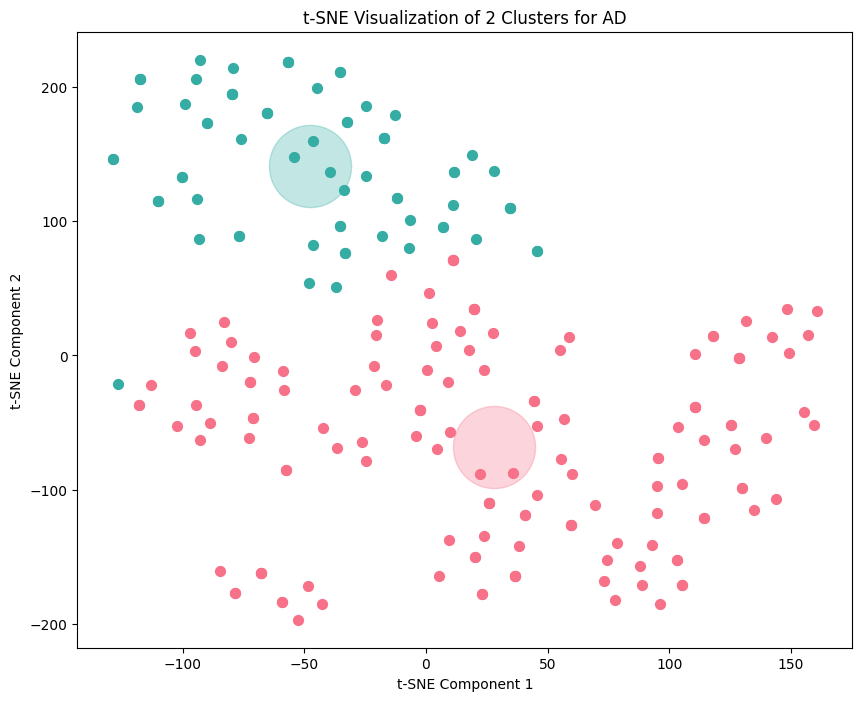

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\3723901779.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


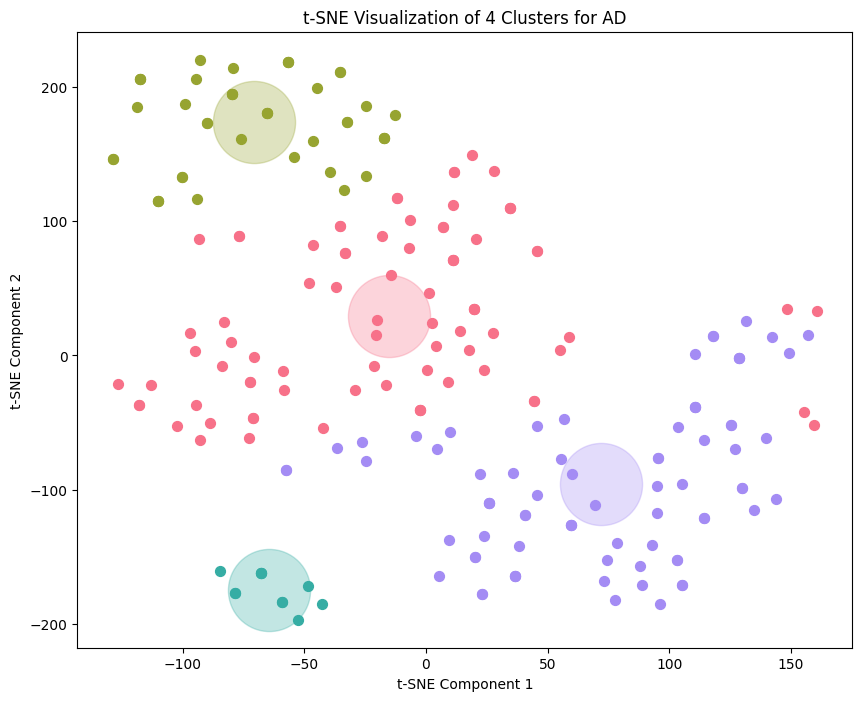

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\3723901779.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


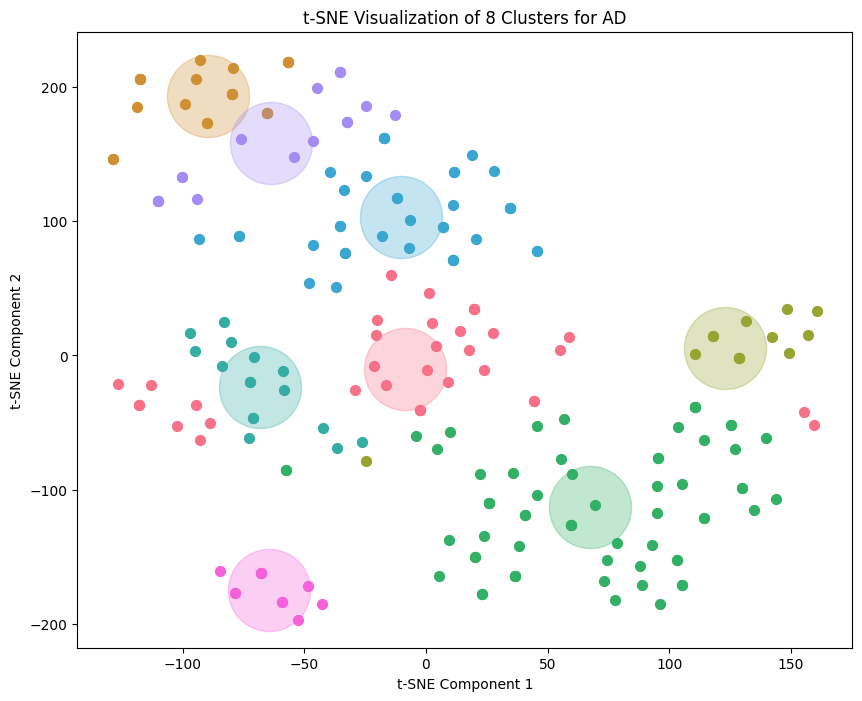

C:\Users\PieHu\AppData\Local\Temp\ipykernel_10956\3723901779.py:21: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_stat, p_value = f_oneway(*feature_data)


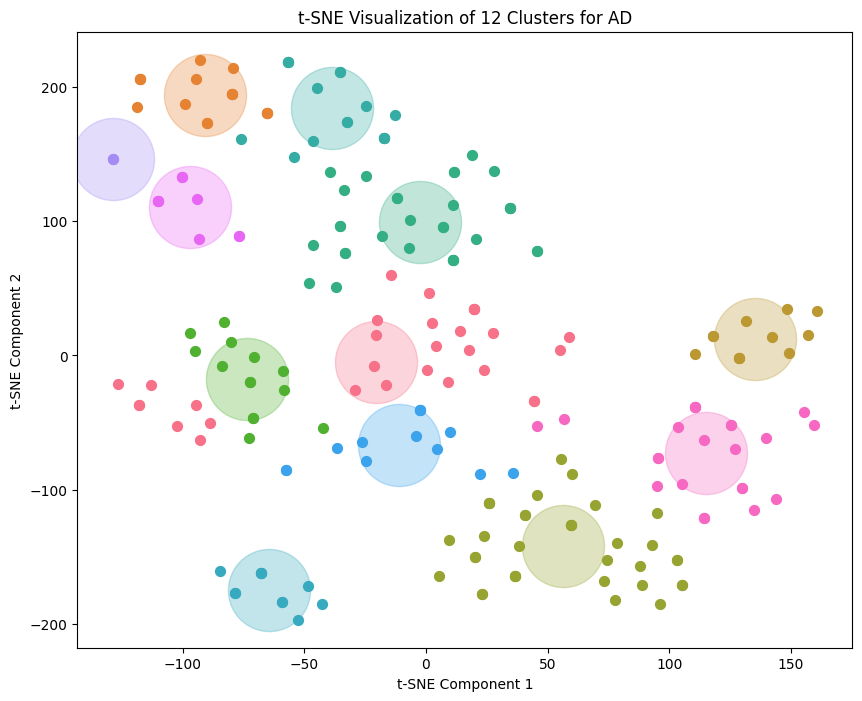

In [21]:
group = "AD"
group_latent = latent[1787 : 2000]
for n_clusters in [2,4, 8, 12]:
    labels, p_values_samples = find_clusters(group_latent, n_clusters=n_clusters)
    plot_clusters(group_latent, labels, n_clusters=n_clusters,title=f't-SNE Visualization of {n_clusters} Clusters for {group}')

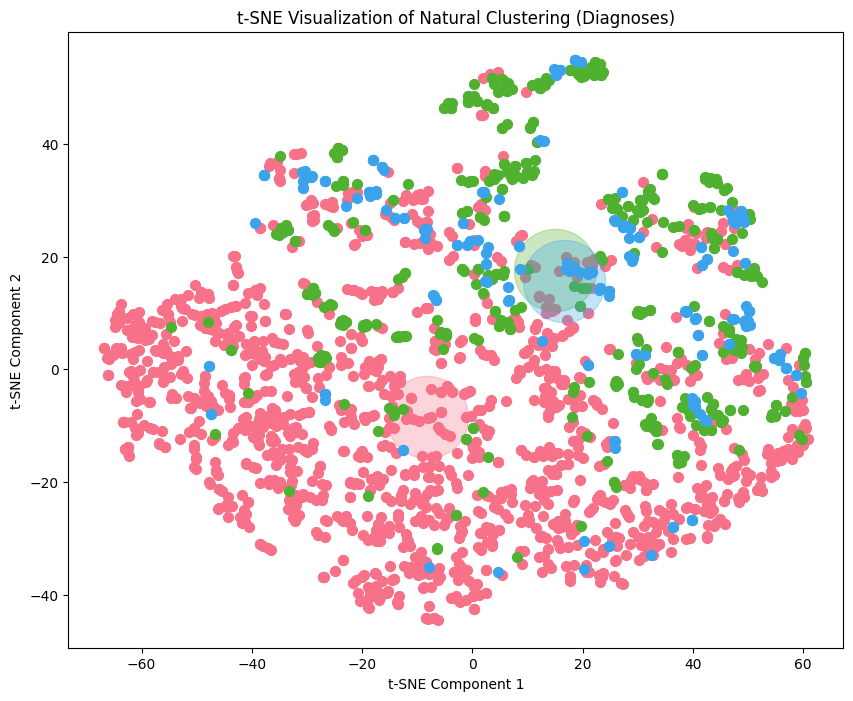

In [19]:
labels_nat = np.zeros(len(latent))
labels_nat[1326 : 1787]=1
labels_nat[1787 : 2000]=2
plot_clusters(latent, labels_nat, n_clusters=3,title='t-SNE Visualization of Natural Clustering (Diagnoses)')